In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [6]:
base_dir = 'datasets'
val_dir = os.path.join(base_dir, 'Validation')
train_dir = os.path.join(base_dir, 'Training')


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_set = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(128, 128), 
    batch_size= 32,
    class_mode='categorical',
)


val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
)

Found 47229 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [9]:
keras_model = MobileNetV2(
    input_shape=(128, 128, 3),
    alpha=1.0,
    weights='imagenet',
    include_top=False
)

keras_model.trainable=False

keras_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [10]:
model = Sequential(
    [
        keras_model,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(2, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 4, 4, 128)         163968    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 2,426,050
Trainable params: 168,066
Non-trainable params: 2,257,984
________________________________________

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
checkpoint = ModelCheckpoint("Gender.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',patience=10,verbose=1)

In [13]:
history = model.fit(
    train_set,
    validation_data = val_set,
    epochs=10,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/10
1476/1476 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8860
Epoch 1: val_accuracy improved from -inf to 0.91252, saving model to Gender.h5
1476/1476 [==============================] - 490s 331ms/step - loss: 0.2808 - accuracy: 0.8860 - val_loss: 0.2247 - val_accuracy: 0.9125
Epoch 2/10
1476/1476 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9087
Epoch 2: val_accuracy did not improve from 0.91252
1476/1476 [==============================] - 136s 92ms/step - loss: 0.2272 - accuracy: 0.9087 - val_loss: 0.2539 - val_accuracy: 0.8952
Epoch 3/10
1476/1476 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9186
Epoch 3: val_accuracy improved from 0.91252 to 0.91999, saving model to Gender.h5
1476/1476 [==============================] - 107s 72ms/step - loss: 0.2108 - accuracy: 0.9186 - val_loss: 0.2011 - val_accuracy: 0.9200
Epoch 4/10
1476/1476 [==============================] - ETA: 0s - loss: 0.2045 - accu

In [14]:
loss, acc = model.evaluate(val_set)
print("Accuracy: {:.2f}".format(acc))
print("Loss: {:.2f}".format(loss))

365/365 [==============================] - 6s 17ms/step - loss: 0.1830 - accuracy: 0.9304
Accuracy: 0.93
Loss: 0.18


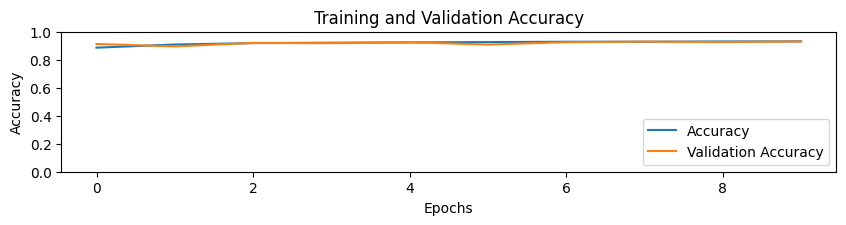

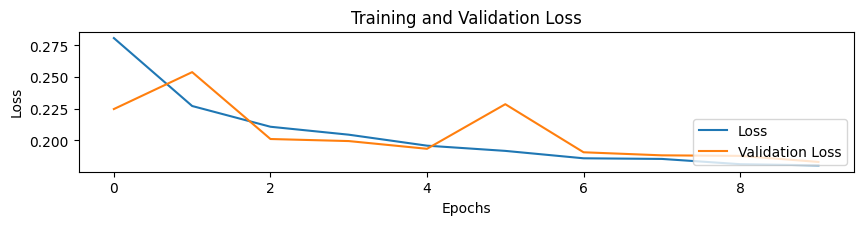

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,4))
ax = plt.subplot(2, 1, 1)
ax.plot(accuracy, label="Accuracy")
ax.plot(val_accuracy, label="Validation Accuracy")
ax.legend(loc="lower right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Training and Validation Accuracy")
ax.set_ylim([0,1])
plt.show()

plt.figure(figsize=(22,4))
ax = plt.subplot(2, 2, 1)
ax.plot(loss, label="Loss")
ax.plot(val_loss, label="Validation Loss")
ax.legend(loc="lower right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
plt.show()

In [12]:
import cv2

In [16]:
def checking(img):
    label = {0:"female",1:"male"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier("datasets/Input/haarcascade_frontalface_default.xml")
    faces = cascade.detectMultiScale(gray,1.1,7)#1.1
    
    for x,y,w,h in faces:
        face = image[y:y+h,x:x+w]
        face = cv2.resize(face,(128,128))
        img_scaled = face/255.0
        reshape = np.reshape(img_scaled,(1,128,128,3))
        img = np.vstack([reshape])
        result = model.predict(img)
        
        predicted_class = np.argmax(result, axis=1)[0]
        if predicted_class == 0:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
            
            
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
                
            
                
        elif predicted_class == 1:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
plt.show()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 483ms/step


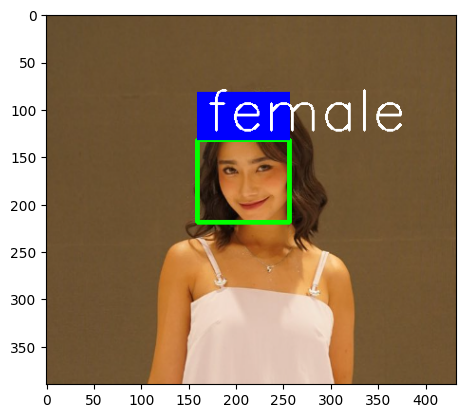

In [17]:
checking('datasets/Input/Screenshot 2024-11-21 132804.png')

1/1 [==============================] - 0s 47ms/step


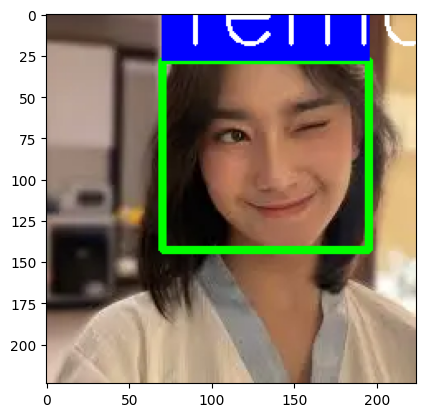

In [18]:
checking('datasets/Input/images.png')

1/1 [==============================] - 0s 48ms/step


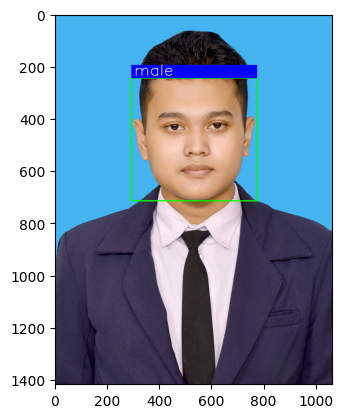

In [19]:
checking('datasets/Input/Pas Foto.jpg')

In [ ]:
# keras.models.save_model(model, "D:/Kuliah/Polinema/Semester 5/Machine Learning/faceCount_model/saved_model", save_format='tf')
# model.save("D:/Kuliah/Polinema/Semester 5/Machine Learning/faceCount_model/saved_model", save_format='tf')

INFO:tensorflow:Assets written to: D:/Kuliah/Polinema/Semester 5/Machine Learning/faceCount_model/saved_model\assets


INFO:tensorflow:Assets written to: D:/Kuliah/Polinema/Semester 5/Machine Learning/faceCount_model/saved_model\assets


In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 1. Load model yang sudah dilatih
model = load_model("saved_model/gender.h5")  # Ganti dengan path model Anda
# model.allocate_tensors()
input_size = (128, 128)  # Ganti ukuran sesuai dengan input model Anda

# Load Haar Cascade untuk deteksi wajah
face_cascade = cv2.CascadeClassifier("datasets/Input/haarcascade_frontalface_default.xml")

# 2. Fungsi untuk memproses gambar sebelum dimasukkan ke model
def preprocess_image(face):
    # Resize gambar sesuai dengan ukuran input model
    resized_face = cv2.resize(face, input_size)
    # Normalisasi pixel (jika diperlukan oleh model)
    normalized_face = resized_face / 255.0
    # Tambahkan batch dimension
    input_face = np.expand_dims(normalized_face, axis=0)
    return input_face

# 3. Inisialisasi kamera
cap = cv2.VideoCapture(1)  # 0 adalah kamera default. Gunakan 1 untuk kamera eksternal.

# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
# cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))  # Ensure supported color format

# ret, frame = cap.read()
# gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# cv2.imshow("Grayscale Feed", gray_frame)



if not cap.isOpened():
    print("Error: Tidak dapat mengakses kamera.")
    exit()

print("Tekan 'q' untuk keluar.")

# 4. Loop untuk menangkap frame dari kamera
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Tidak dapat membaca frame dari kamera.")
        break

    # Konversi frame ke grayscale untuk deteksi wajah
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=7)

    for (x, y, w, h) in faces:
        # Ambil region wajah
        face = frame[y:y+h, x:x+w]

        # Proses wajah dan buat prediksi
        input_face = preprocess_image(face)
        prediction = model.predict(input_face)

        # Dapatkan kelas prediksi
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction)

        # Tampilkan label berdasarkan prediksi
        label = f"Class: {'Male' if predicted_class == 1 else 'Female'}, Confidence: {confidence:.2f}"
        
        # Tambahkan kotak di sekitar wajah
        color = (0, 255, 0) if predicted_class == 0 else (0, 0, 255)  # Warna berdasarkan prediksi
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Tampilkan frame di jendela
    cv2.imshow("Live Camera Feed", frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 5. Tutup kamera dan jendela
cap.release()
cv2.destroyAllWindows()


Tekan 'q' untuk keluar.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
import tensorflow as tf

# Load model TensorFlow
model = tf.keras.models.load_model("Gender.h5")

# Konversi ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam format .tflite
with open("Gender.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite.")


INFO:tensorflow:Assets written to: C:\Users\LOQ\AppData\Local\Temp\tmpkku35b9j\assets


INFO:tensorflow:Assets written to: C:\Users\LOQ\AppData\Local\Temp\tmpkku35b9j\assets


Model berhasil dikonversi ke TensorFlow Lite.
